# ITCS 3156-091 Final Project: Steam Review Sentiment Analysis

## Name: **Jason Khotsombath**

### Imports, Installs, and Utils

In [1]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [26]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Steam Review Dataset

<center><img src="https://storage.googleapis.com/kaggle-datasets-images/1754525/2865229/aacab271ac39a043c556e617d148bb94/dataset-cover.png?t=2021-11-29-10-49-35"
width="600"
height="300"></img></center>

For my project, we will be using the [Steam Review Dataset](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data) by user [Larxel](https://www.kaggle.com/andrewmvd). This dataset contains 6.4 million publically available English reviews of from the Steam Reviews segment of the Steam store ran by Valve in 2017. On the Kaggle, the author suggests you can create a sentiment analysis algorithm to predict scores given review text and explore sentiment with review topics across games and genres. We will be doing the first option to predict scores based on review text. This is important specifically for game developers to understand player reception to their games, trend analysis for specific mechanics based on review text, and allows insights into what features/mechanics players value the most.

**Inputs/Features**

| Name                          | Data Type   | Description | Provided in Dataset |
|-------------------------------|------------|-------------|---------------|
| Game ID                    | Quantitative               | ID of the Game stored in the Steam Database | True |
| Game Name              | Quantitative         | Name of the Game stored in the Steam Database | True 
| Review Text                 | Quantitative          | The text input of the review text for that review | True |
| Review Text Word Count         | Quantitative | Number of characters in the Review Text of that review | False |
| Review Votes | Quantitative | Whether the review was recommended by another user or not | True |

**Target**

| Name                          | Data Type  | Description | Provided in Dataset |
|-------------------------------|-------------|-------------|----|
| Review Score | Quantitative     |  Whether the game the review recommends the game or not | True |

# Data Loading

In [ ]:
# Make sure you download the dataset and place it in the same directory as this file.
# If the dataset is named as "dataset.csv", rename it to "SteamReviews.csv"
# Warning: The dataset is large, ~1-1.5min to load
steam_reviews_df = pd.read_csv('SteamReviews.csv')

In [29]:
# Sample Size or it'll blow up your computer
steam_reviews_df = steam_reviews_df.sample(n=50000, random_state=np.random.randint(0,10000))

In [30]:
# Adding Word Count as a feature
steam_reviews_df['word_count'] = steam_reviews_df['review_text'].str.split().str.len()

In [31]:
steam_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1736627 to 1960063
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   app_id        50000 non-null  int64  
 1   app_name      48580 non-null  object 
 2   review_text   49938 non-null  object 
 3   review_score  50000 non-null  int64  
 4   review_votes  50000 non-null  int64  
 5   word_count    49938 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


In [32]:
steam_reviews_df.describe()

,app_id,review_score,review_votes,word_count
count,50000.000000,50000.000000,50000.000000,49938.000000
mean,228349.918520,0.638640,0.150480,55.205034
std,125674.266633,0.769513,0.357545,107.393810
min,10.000000,-1.000000,0.000000,0.000000
25%,203140.000000,1.000000,0.000000,6.000000
50%,239350.000000,1.000000,0.000000,19.000000
75%,305620.000000,1.000000,0.000000,57.000000
max,563430.000000,1.000000,1.000000,1990.000000


# Visualization

## Numeric Features
### Correlation between all numeric features

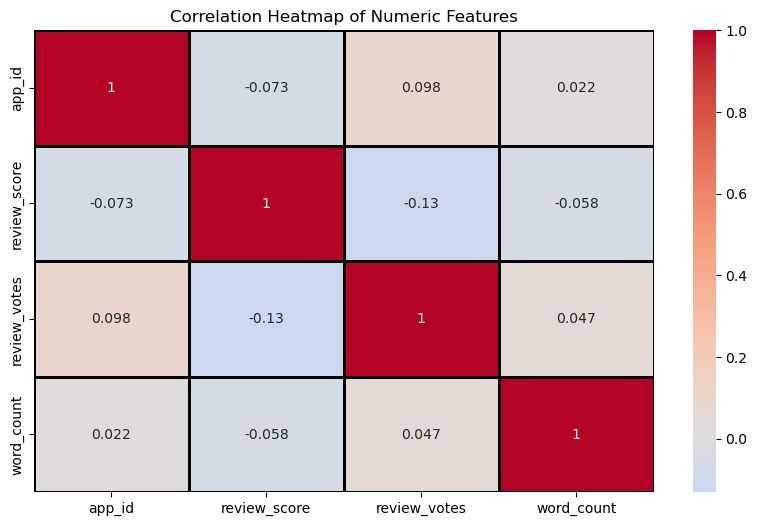

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = steam_reviews_df.drop(columns=['review_text', 'app_name'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black'),
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Word Count by Sentiment
### Distribution of word count by sentiment

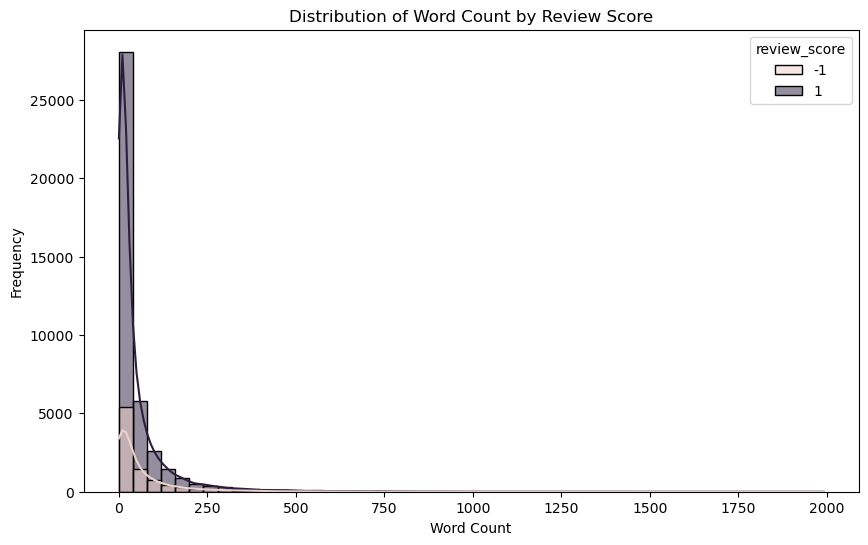

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=steam_reviews_df, x='word_count', hue='review_score', bins=50, kde=True)
plt.title('Distribution of Word Count by Review Score')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Game Distribution
### Top Games by review count

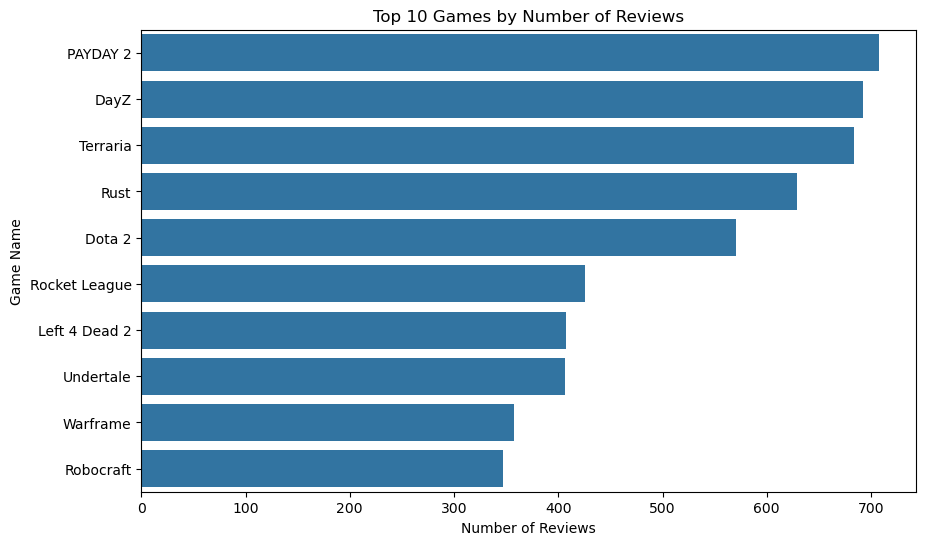

In [35]:
top_games_df = steam_reviews_df['app_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games_df.values, y=top_games_df.index)
plt.title('Top 10 Games by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Game Name')
plt.show()

## Sentiment Score Distribution
### Pie Chart of Postive to Negative Reviews

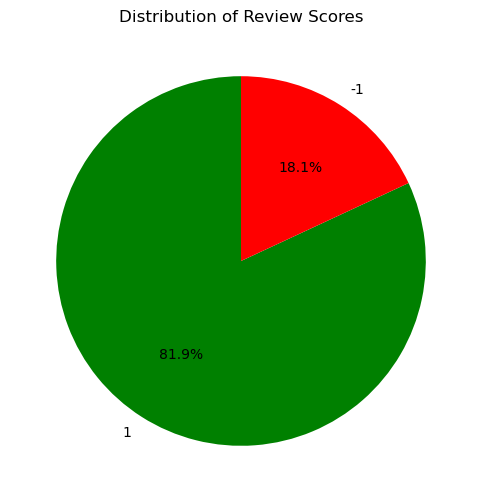

In [36]:
plt.figure(figsize=(10, 6))
steam_reviews_df['review_score'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Review Scores')
plt.ylabel('')
plt.show()

## Word Cloud
### Word clouds of the most common words for positive and negative reviews.

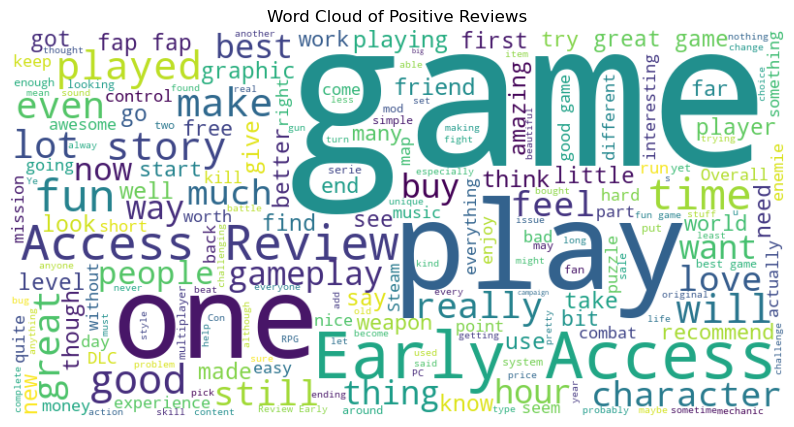

In [37]:
from wordcloud import WordCloud

steam_reviews_df['review_text'] = steam_reviews_df['review_text'].astype(str).replace('nan', '')
positive_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == 1]['review_text'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

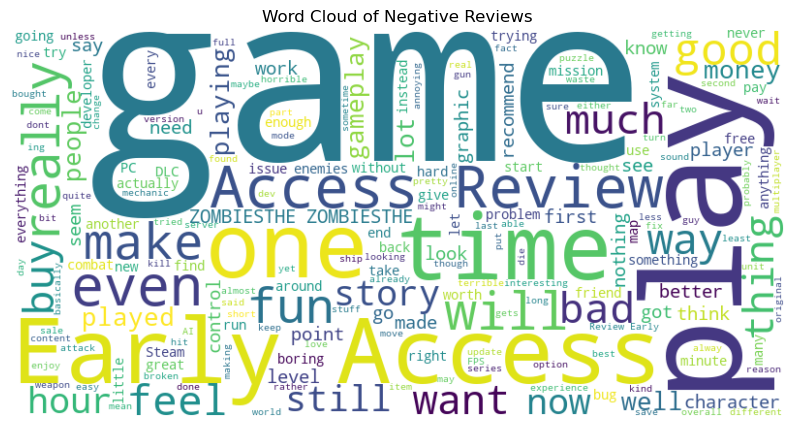

In [38]:
negative_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == -1]['review_text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

## Review Length by Sentiment
### Correlation between the review score and the word count of the review.

Text(0, 0.5, 'Word Count')

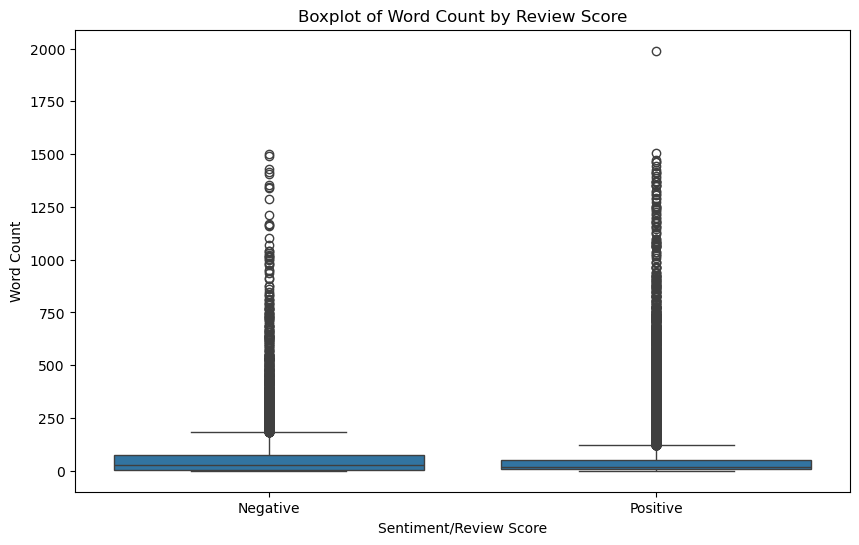

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='word_count', data=steam_reviews_df)
plt.title('Boxplot of Word Count by Review Score')
plt.xlabel('Sentiment/Review Score')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.ylabel('Word Count')